Import Libraries and Load NLP Pipeline

In [16]:
import json
import spacy
import matplotlib.pyplot as plt
import numpy as np

nlp = spacy.load('en_core_web_sm')

Define Topics and Import Texts

In [17]:
# Topics to analyze
topics = [
    "text similarity measure",
    "semantic similarity",
    "information retrieval",
    "keyword extraction",
    "text summarization",
    "classification",
    "clustering",
    "topic modelling",
    "sentiment analysis"
]

# Import texts and group by year
files = [
    'papers-semeval-2021.json',
    'papers-semeval-2022.json',
    'papers-semeval-2023.json',
    'papers-semeval-2024.json'
]

corpora_by_year = {}

for filename in files:
    with open(filename, 'r', encoding='utf-8') as f:
        data = json.load(f)
        year = filename[15:19]
        corpora_by_year[year] = [item['abstract'] for item in data]

Preprocess Abstracts

In [18]:
def preprocess_texts(abstracts):
    processed_texts = []
    for abstract in abstracts:
        doc = nlp(abstract.lower())
        lemmas = [token.lemma_ for token in doc if token.is_alpha]
        processed_texts.append(' '.join(lemmas))
    return processed_texts

# Preprocess abstracts by year
preprocessed_by_year = {
    year: preprocess_texts(abstracts) for year, abstracts in corpora_by_year.items()
}

Count Topic Mentions

In [19]:
# Define a function to count topic mentions in a corpus
def count_topic_mentions(corpus, topics):
    topic_counts = {topic: 0 for topic in topics}
    for topic in topics:
        topic_tokens = topic.split()
        for text in corpus:
            if all(token in text for token in topic_tokens):
                topic_counts[topic] += 1
    return topic_counts

# Calculate topic counts by year
topic_trends = {}
for year, corpus in preprocessed_by_year.items():
    counts = count_topic_mentions(corpus, topics)
    topic_trends[year] = counts

# Print topic trends
for year, trends in topic_trends.items():
    print(f"\nYear: {year}")
    for topic, count in trends.items():
        print(f" - {topic}: {count}")


Year: 2021
 - text similarity measure: 1
 - semantic similarity: 1
 - information retrieval: 1
 - keyword extraction: 0
 - text summarization: 0
 - classification: 55
 - clustering: 1
 - topic modelling: 0
 - sentiment analysis: 1

Year: 2022
 - text similarity measure: 2
 - semantic similarity: 5
 - information retrieval: 0
 - keyword extraction: 1
 - text summarization: 1
 - classification: 75
 - clustering: 0
 - topic modelling: 0
 - sentiment analysis: 23

Year: 2023
 - text similarity measure: 0
 - semantic similarity: 3
 - information retrieval: 6
 - keyword extraction: 0
 - text summarization: 1
 - classification: 82
 - clustering: 1
 - topic modelling: 0
 - sentiment analysis: 25

Year: 2024
 - text similarity measure: 5
 - semantic similarity: 17
 - information retrieval: 2
 - keyword extraction: 0
 - text summarization: 2
 - classification: 60
 - clustering: 0
 - topic modelling: 0
 - sentiment analysis: 4


Visualize Topic Trends

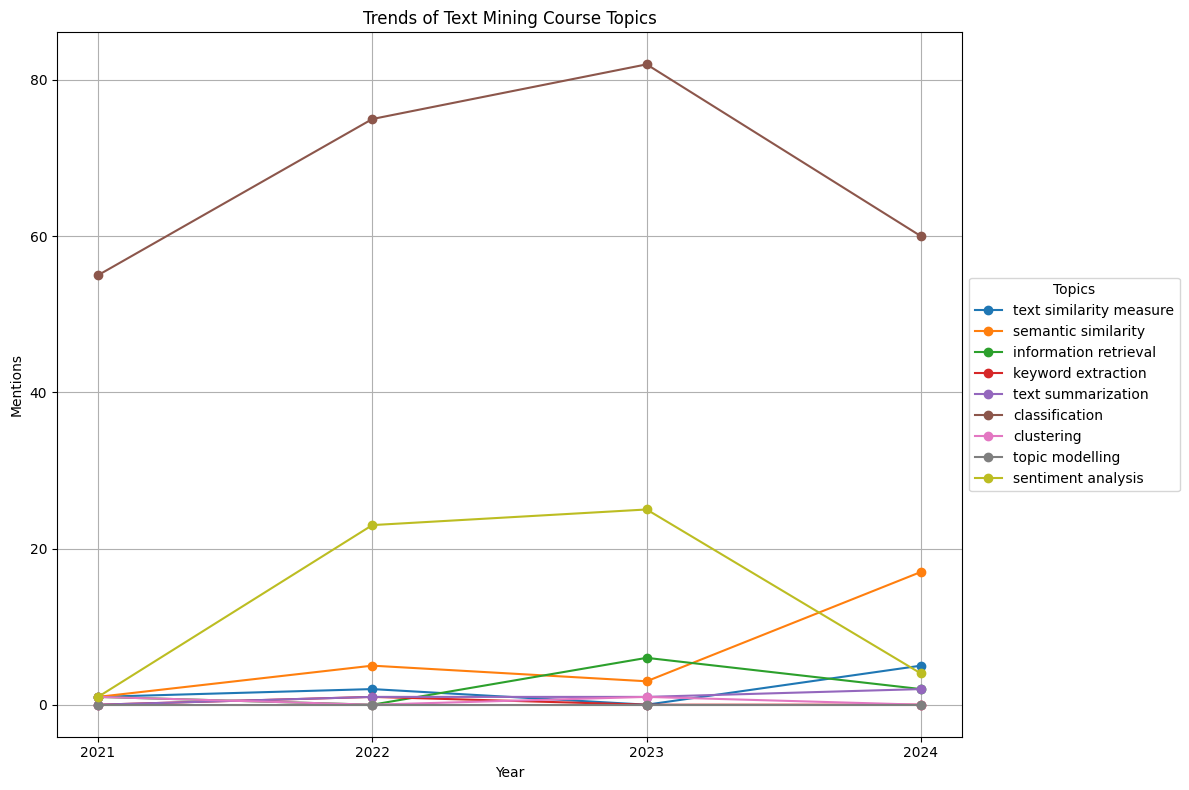

In [20]:
# Convert trends into a matrix for visualization
years = sorted(topic_trends.keys())
topic_matrix = np.array([[topic_trends[year][topic] for year in years] for topic in topics])

# Plot trends for each topic
plt.figure(figsize=(12, 8))
for idx, topic in enumerate(topics):
    plt.plot(years, topic_matrix[idx], marker='o', label=topic)

plt.title("Trends of Text Mining Course Topics")
plt.xlabel("Year")
plt.ylabel("Mentions")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Topics")
plt.grid(True)
plt.tight_layout()
plt.show()